In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
from scipy.signal import find_peaks

# Medición de ancho (wave driver):

Usé este mismo código para sacar el ancho en px de 1) el palito en la superficie del experimento del wave driver que usamos como referencia 2) diámetro de los filamentos en las fotos que sacó Miguel en el microscopio. 

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\pauli\AppData\Local\Temp\ipykernel_8728\4048285388.py:1: SyntaxWarning: invalid escape sequence '\c'
  im = cv2.imread('fotos\calibracion filamento microscopio\\filamento-x10.tif')


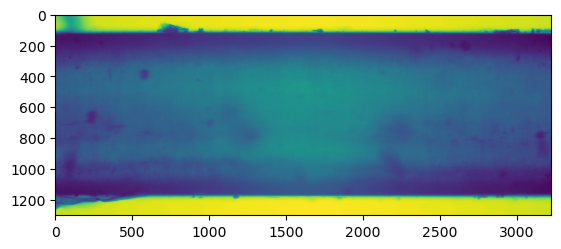

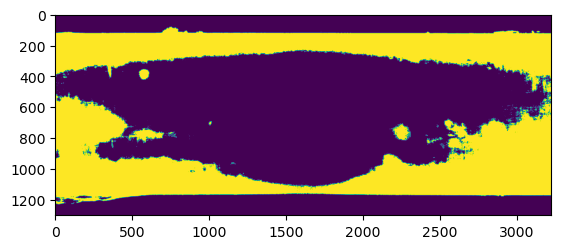

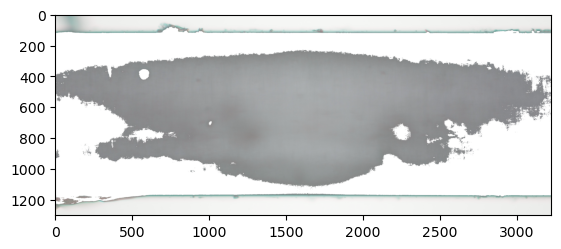

In [ ]:
im = cv2.imread('fotos\calibracion filamento microscopio\\filamento-x10.tif')

im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(im_gs)

_, im_th = cv2.threshold(im_gs, 135, 255, cv2.THRESH_BINARY)

# p/ remito_dado_vuelta: 75 de threshold
# p/ filamento-x10: 135

im_th = cv2.bitwise_not(im_th)

y, x  = np.where(im_th == 255)

im_show = im.copy()

im_show[y, x] = 255
plt.figure()
plt.imshow(im_th)
np.shape(im_th)

plt.figure()
plt.imshow(im_show)

918 1103


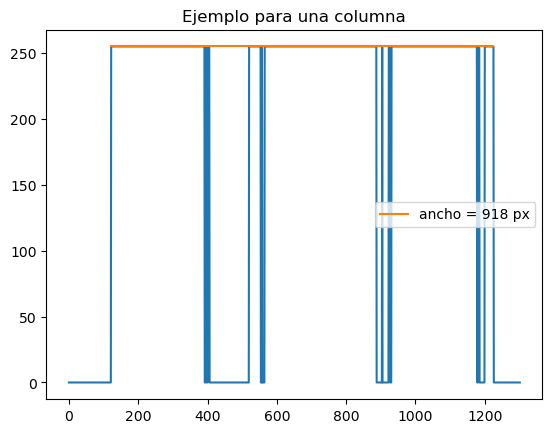

In [10]:
col = im_th[:,0]
bar = np.where(col==255)[0]
width = bar[-1] - bar[0]
print(len(bar), width)

plt.plot(col)
plt.title('Ejemplo para una columna')
plt.plot([bar[0], bar[-1]], [255, 255], label=f'ancho = {len(bar)} px')
plt.legend()

In [11]:
cols = [im_th[:, i] for i in range(np.shape(im_th)[1])]
len(cols)

widths = []
widths2 = []
for c in cols:
    bar = np.where(c==255)[0]
    width2 = len(bar)
    width = bar[-1] - bar[0]
    widths.append(width)
    widths2.append(width2)

mean_width = np.mean(widths)
width_err = np.std(widths)/np.sqrt(len(widths))

mean_width2 = np.mean(widths2)
width2_err = np.std(widths2)/np.sqrt(len(widths2))

In [15]:
# FILAMENTOS:

UM_PER_PX = 0.4245033304856029
UM_PER_PX_ERROR = 0.00020834189731838294

print(np.shape(im_th))
print(f'Ancho en píxeles del filamento: {mean_width} +- {width_err}\nAncho en micrones: {mean_width*UM_PER_PX} +- {width_err*UM_PER_PX + mean_width*UM_PER_PX_ERROR}')


(1302, 3222)
Ancho en píxeles del filamento: 1055.7330850403475 +- 0.279206893027264
Ancho en micrones: 448.16221070346774 +- 0.33847768998370675


In [ ]:
WIDTH_CUERPO = 2.36
width_calibre_err = 0
WIDTH_CABEZA = 6.79

PX_PER_MM2 = mean_width2/WIDTH_CABEZA
ERR_PX_MM2 = width2_err/WIDTH_CABEZA

# print(f'ancho promedio: {mean_width} +- {width_err}')
# print(f'px per mm: {PX_PER_MM} +- {ERR_PX_MM}')

print(f'ancho2 promedio: {mean_width2} +- {width2_err}')
print(f'px per mm: {PX_PER_MM2} +- {ERR_PX_MM2}')

# print(width2_err/width_calibre, np.std(widths2)/width_calibre)

ancho2 promedio: 32.97560975609756 +- 0.017034885262672637
px per mm: 4.856496282194044 +- 0.002508819626314085


# Diámetro del filamento para cada video

Ancho en px de los filamentos para cada uno de los videos de laboratorio 7

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
import DSE_prune
from skimage.measure import label, regionprops, regionprops_table

THRESHOLD = 100
MAX_PIXEL_VALUE = 255

In [2]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

In [18]:
# itero y saco un frame de trabajo por cada video:

import os
import pandas as pd

for filename in os.listdir('videos\\FCD\\P1\\telgopor'):
    vs = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    length = int(vs.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if i == length//2:
                frame = cortar(frame, lim)
                # Guardo las fotos
                spl = filename[:-4].split('-')
                v,f = spl[1],spl[2]
                cv.imwrite(f'fotos\\capturas calibracion\\captura-{v}-{f}.tiff', frame)
                print(f'guardado: {filename}')
                break
            i+=1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Hubo un problema que se yo", filename)
            break
    print('siguiente')

cv.destroyAllWindows()

guardado: P1-1V-10Hz-60mm.mp4
siguiente
guardado: P1-1V-15Hz-60mm.mp4
siguiente
guardado: P1-1V-5Hz-60mm.mp4
siguiente
guardado: P1-2V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-15Hz-60mm.mp4
siguiente
guardado: P1-2V-5Hz-60mm.mp4
siguiente
guardado: P1-3V-10Hz-60mm.mp4
siguiente
guardado: P1-3V-5Hz-60mm.mp4
siguiente
guardado: P1-4V-5Hz-60mm.mp4
siguiente
siguiente


In [19]:
problematicos = ['P1-3V-10Hz-60mm.mp4', 'P1-2V-10Hz-60mm.mp4', 'P1-1V-10Hz-60mm.mp4', 'P1-2V-15Hz-60mm.mp4']

for filename in problematicos:
    vs = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    length = int(vs.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if i == 2*(length//3):
                frame = cortar(frame, lim)
                # frame = gris(frame)
                # Guardo las fotos
                spl = filename[:-4].split('-')
                v,f = spl[1],spl[2]
                cv.imwrite(f'fotos\\capturas calibracion\\captura-{v}-{f}.tiff', frame)
                print(f'guardado: {filename}')
                break
            i+=1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Hubo un problema que se yo", filename)
            break
    print('siguiente')

cv.destroyAllWindows()

guardado: P1-3V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-10Hz-60mm.mp4
siguiente
guardado: P1-1V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-15Hz-60mm.mp4
siguiente


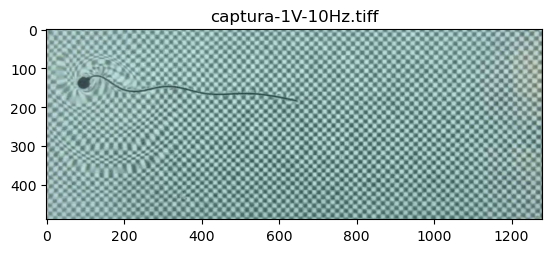

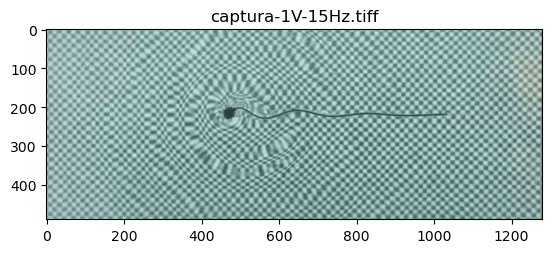

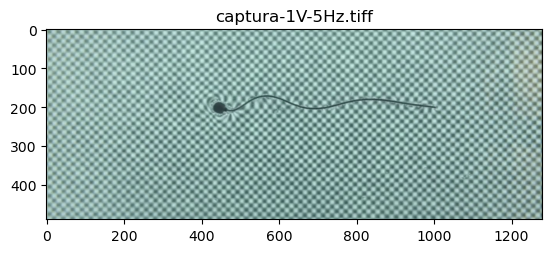

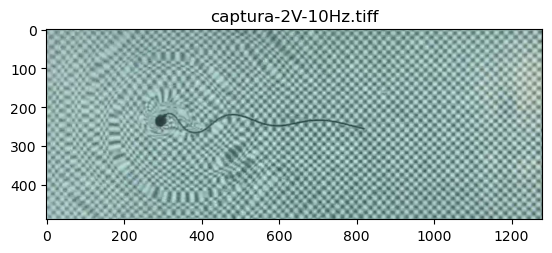

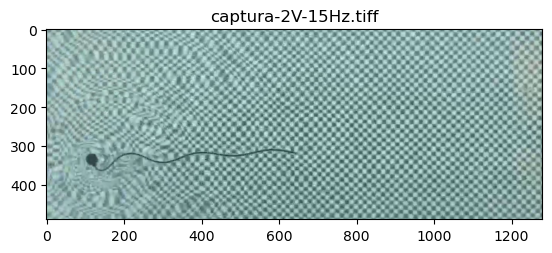

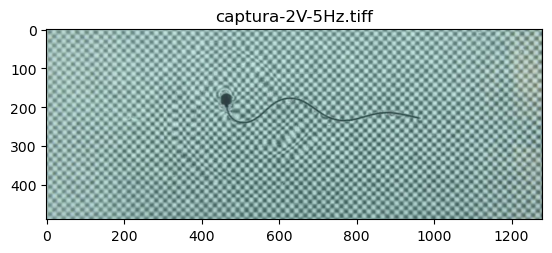

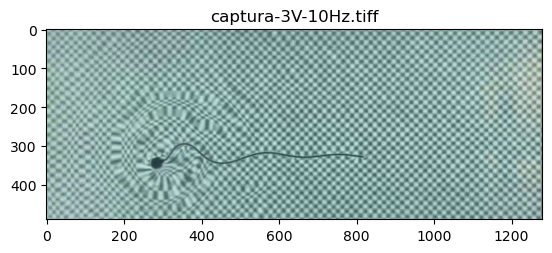

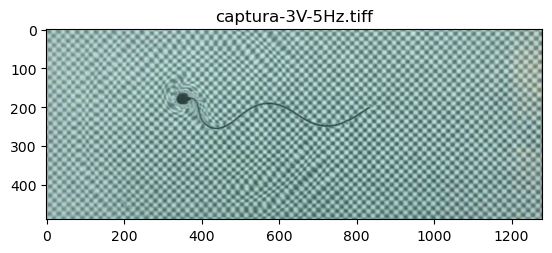

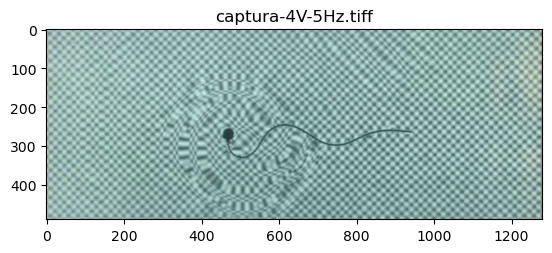

In [20]:
for filename in os.listdir('fotos\\capturas calibracion'):
    captura = skimage.io.imread(f'fotos\\capturas calibracion\\{filename}')
    plt.figure()
    plt.title(f'{filename}')
    plt.imshow(captura)

In [ ]:
im = skimage.io.imread(f'capture-P1-2V-9Hz-color.tiff')
plt.imshow(im)
im_copy = im.copy()

In [ ]:
# ref_sobel = sobel(im)
ref_gray = gris(im)

ref_gaussian = gaussian(ref_gray, 4)

plt.figure()
plt.imshow(ref_gaussian)
# plt.colorbar()

In [ ]:
ref_binary = binarize(ref_gaussian, th=0.5)

plt.figure()
plt.imshow(ref_binary)

y, x = np.where(ref_binary!=0)
# y_sk, x_sk = np.where(ref_DSE!=0)
# im_copy[y,x] = [0, 255, 0]
# plt.imshow(im_copy)

In [ ]:

labeled_image = label(1-ref_binary, connectivity=1)
regions = regionprops(labeled_image)

object_features = skimage.measure.regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
print(object_areas)
print(object_areas[15])
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
plt.figure()
plt.imshow(labeled_image)
print(sorted(object_areas, reverse=True)[:2])
print(object_areas[n])

In [ ]:
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
area  =  mask

print(area)
plt.figure(figsize=(300, 25))
plt.imshow(area)

In [ ]:
im = skimage.io.imread(f'capture-P1-2V-9Hz-color.tiff')
plt.imshow(im)
im_copy = im.copy()

In [ ]:
y, x = np.where(area!=0)
# y_sk, x_sk = np.where(ref_DSE!=0)

line_th = skimage.morphology.thin(area)
y_t, x_t = np.where(line_th!=0) 
# line_sk = skimage.morphology.skeletonize(area)
# y_k, x_k = np.where(line_sk!=0)

im_copy[y, x] = [255,255,255]
# im_copy[y_sk, x_sk] = 0
# im_copy[y_k, x_k] = [0,0,255]
# im_copy[y_t, x_t] = [255,0,0]
plt.figure(figsize=(300, 25))
plt.imshow(im_copy)